# Mục Đích
> Trong phần này chúng ta sẽ cùng đi qua các phương thức để tạo được dataset của tensorflow, bao gồm:
> 1. Load dữ liệu có sẵn của tensorflow_datasets
> 2. Load dữ liệu từ folder
> 3. Load dữ liệu từ file excel

In [ ]:
#default_exp image.basic_dataset

In [ ]:
#export
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#hide
tf.__version__, keras.__version__

('2.4.1', '2.4.0')

In [ ]:
#hide
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


## LOAD DATA ONLINE

### Sử dụng keras datasets

In [ ]:
#export
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train.shape, y_train.shape

((60000, 28, 28), (60000,))

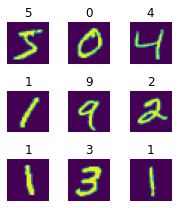

In [ ]:
#export
# Kiểm tra dữ liệu:
fig = plt.figure(figsize=(3, 3))
for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(X_train[i,:])
    plt.title(y_train[i])
    plt.axis('off')
    plt.tight_layout()

In [ ]:
#export
# Biến đổi dữ liệu:
X_train = X_train/255
X_test = X_test/255

In [ ]:
#export
# Kiểm tra dữ liệu sau khi chia cho 225 (giá trị sẽ từ 0 đến 1)
X_train[1, 10:15, 10:15]

array([[0.93333333, 0.98823529, 0.98823529, 0.70196078, 0.04705882],
       [0.99215686, 0.91372549, 0.81568627, 0.32941176, 0.        ],
       [0.94117647, 0.27843137, 0.0745098 , 0.10980392, 0.        ],
       [0.24705882, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ]])

In [ ]:
#export
# Normalize dữ liệu trước khi train, sử dụng mean và variance của imagenet:
# https://forums.fast.ai/t/is-normalizing-the-input-image-by-imagenet-mean-and-std-really-necessary/51338
normalizer = keras.layers.experimental.preprocessing.Normalization(mean=0.485, variance=0.229**2, name='normalize') 
X_train = normalizer(X_train)
X_test = normalizer(X_test)
X_train.shape, X_test.shape

(TensorShape([60000, 28, 28]), TensorShape([10000, 28, 28]))

In [ ]:
#hide
# Kiểm tra dữ liệu sau khi normalize:
X_train[1, 10:15, 10:15]

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[ 1.9577874 ,  2.1975338 ,  2.1975338 ,  0.94742703, -1.9124069 ],
       [ 2.2146587 ,  1.8721637 ,  1.4440448 , -0.67942464, -2.117904  ],
       [ 1.9920369 , -0.9020464 , -1.7925336 , -1.6384109 , -2.117904  ],
       [-1.0390445 , -2.117904  , -2.117904  , -2.117904  , -2.117904  ],
       [-2.117904  , -2.117904  , -2.117904  , -2.117904  , -2.117904  ]],
      dtype=float32)>

#### Tạo neural net cơ bản:

In [ ]:
#export
# Tạo neural net cơ bản:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28), name='flatten'),
    keras.layers.Dense(128, activation='relu', name='layer1'),
    keras.layers.Dropout(.2, name='dropout'),
    keras.layers.Dense(20, activation='relu', name='layer2'),
    keras.layers.Dense(10, activation='softmax', name='predictions')
])
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#export
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
layer1 (Dense)               (None, 128)               100480    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
layer2 (Dense)               (None, 20)                2580      
_________________________________________________________________
predictions (Dense)          (None, 10)                210       
Total params: 103,270
Trainable params: 103,270
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#export
# Đào tạo:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5)

Epoch 1/5
1875/1875 [==============================] - 27s 14ms/step - loss: 0.7879 - accuracy: 0.7550 - val_loss: 0.2252 - val_accuracy: 0.9351
Epoch 2/5
1875/1875 [==============================] - 25s 13ms/step - loss: 0.2794 - accuracy: 0.9202 - val_loss: 0.1679 - val_accuracy: 0.9516
Epoch 3/5
1875/1875 [==============================] - 25s 13ms/step - loss: 0.2335 - accuracy: 0.9332 - val_loss: 0.1658 - val_accuracy: 0.9540
Epoch 4/5
1875/1875 [==============================] - 25s 14ms/step - loss: 0.2091 - accuracy: 0.9410 - val_loss: 0.1439 - val_accuracy: 0.9624
Epoch 5/5
1875/1875 [==============================] - 25s 13ms/step - loss: 0.1919 - accuracy: 0.9462 - val_loss: 0.1377 - val_accuracy: 0.9629


**Lưu ý:** chúng ta sử dụng thêm normalizer để normalize dữ liệu thì kết quả metrics chưa thực sự rõ ràng, tuy nhiên loss được cải thiện tương đối.

#### Thay đổi tốc độ học:
> tốc độ học (learning rate) đi kèm với optimizer trong keras, nên muốn tác động vào lr, chúng ta có thể làm bằng 1 trong 2 cách sau:

_Chọn optimizer bằng method trong keras.optimizers_

In [ ]:
#hide
# Learning rate (tốc độ học) đi kèm với optimizer. Chúng ta có thể tác động vào learning rate với keras.optimizers:
optimizer = keras.optimizers.RMSprop(learning_rate=3e-3)

_Hoặc sử dụng keras backends để sửa learning rate_

In [ ]:
#hide
# Hoặc bằng cách sử dụng backend set_value method:
print('lr before: ', model.optimizer.learning_rate.numpy())
K.set_value(model.optimizer.learning_rate, 0.003)
print('lr after: ', model.optimizer.learning_rate.numpy())

lr before:  0.001
lr after:  0.003


#### Thay đổi hàm loss:
> hàm loss (hàm mất mát) cũng có thể được thay đổi tương tự như learning rate.

In [ ]:
#hide
dir(keras.losses)

['BinaryCrossentropy',
 'CategoricalCrossentropy',
 'CategoricalHinge',
 'CosineSimilarity',
 'Hinge',
 'Huber',
 'KLD',
 'KLDivergence',
 'LogCosh',
 'Loss',
 'MAE',
 'MAPE',
 'MSE',
 'MSLE',
 'MeanAbsoluteError',
 'MeanAbsolutePercentageError',
 'MeanSquaredError',
 'MeanSquaredLogarithmicError',
 'Poisson',
 'Reduction',
 'SparseCategoricalCrossentropy',
 'SquaredHinge',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_sys',
 'binary_crossentropy',
 'categorical_crossentropy',
 'categorical_hinge',
 'cosine_similarity',
 'deserialize',
 'get',
 'hinge',
 'huber',
 'kl_divergence',
 'kld',
 'kullback_leibler_divergence',
 'log_cosh',
 'logcosh',
 'mae',
 'mape',
 'mean_absolute_error',
 'mean_absolute_percentage_error',
 'mean_squared_error',
 'mean_squared_logarithmic_error',
 'mse',
 'msle',
 'poisson',
 'serialize',
 'sparse_categorical_crossentropy',
 'squared_hinge']

In [ ]:
#export
# tạo hàm loss:
loss_func = keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer=optimizer, loss=loss_func, metrics='accuracy')

In [ ]:
#export
# Đào tạo lại
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2)

Epoch 1/2
1875/1875 [==============================] - 25s 13ms/step - loss: 0.4321 - accuracy: 0.8950 - val_loss: 0.2278 - val_accuracy: 0.9349
Epoch 2/2
1875/1875 [==============================] - 25s 13ms/step - loss: 0.3503 - accuracy: 0.9128 - val_loss: 0.2326 - val_accuracy: 0.9451


#### Thay đổi metrics
> Tương tự như lr và loss, chúng ta cũng có thể thay đổi metrics.

In [ ]:
# precision = keras.metrics.Precision()
# recall = keras.metrics.Recall()

In [ ]:
# Tạo hàm F1Score dự vào True Positive (TP), False Positive (FP) và False Negative (FN):
# def f1(y_true, y_pred):
#     # Tính True Positive:
#     TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     # Tính Actual Positve: TP + FN
#     TP_FN = K.sum(K.round(K.clip(y_true, 0, 1)))
#     # Tính Predicted Positve: TP + FP
#     TP_FP = K.sum(K.round(K.clip(y_pred, 0, 1)))
#     return  (2 * TP)/(TP_FN + TP_FP + K.epsilon())

In [ ]:
#export
model.compile(optimizer=optimizer, loss=loss_func, metrics=['accuracy'])

In [ ]:
#export
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
layer1 (Dense)               (None, 128)               100480    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
layer2 (Dense)               (None, 20)                2580      
_________________________________________________________________
predictions (Dense)          (None, 10)                210       
Total params: 103,270
Trainable params: 103,270
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#export
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1, batch_size=32)

1875/1875 [==============================] - 26s 14ms/step - loss: 0.3307 - accuracy: 0.9214 - val_loss: 0.2891 - val_accuracy: 0.9450


### Sử dụng tensorflow_datasets

**Lưu ý:**
Với dữ liệu từ tensorflow_datasets (tfds), chúng ta cần lưu ý 1 điểm tương đối quan trọng sau:
- Với dữ liệu có sẵn, tfds cung cấp option dữ liệu trả về bằng 2 dạng: 1) dictionary; 2) tupple.
- Việc lựa chọn 1 trong 2 dạng này được thông qua argument: `as_supervised` (default = False)
    - `as_supervised=False`: dữ liệu trả vể (train_ds, valid_ds) ở dạng `dictionary`
    - `as_supervised=True`: dữ liệu trả về (train_ds, valid_ds) ở dạng `tupple`
- Trong quá trình fit model sử dụng dữ liệu từ tfds, chúng ta cần lưu ý là model nhận dữ liệu dạng tupple, do đó, việc sử dụng dữ liệu tfds cần lưu ý bước chọn `as_supervised` ở trên.

#### Dữ liệu dạng dictionary

In [ ]:
#export
train_ds, test_ds = tfds.load('fashion_mnist', split=['train', 'test'], shuffle_files=True, batch_size=32)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling fashion_mnist-train.tfrecord...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling fashion_mnist-test.tfrecord...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /home/ddpham/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
#hide
# In keys của images:
for images in train_ds.take(1):
    print(images.keys())
    break

dict_keys(['image', 'label'])


##### Visualize

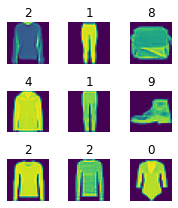

In [ ]:
#export
# Kiểm tra dữ liệu:
plt.figure(figsize=(3, 3))
# Nếu sử dụng batch_size trong hàm load:
for images in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images['image'][i])
        plt.title(images['label'][i].numpy())
        plt.axis("off")
        plt.tight_layout()

#### Dữ liệu dạng tupple
> Đây là dạng dữ liệu chúng ta cần để đào tạo model

In [ ]:
#export
train_ds, valid_ds = tfds.load('fashion_mnist', split=['train', 'test'], shuffle_files=True, batch_size=64, as_supervised=True)

In [ ]:
#export
# Kiểm tra shape:
for images in train_ds.take(1):
    print('Number of items:', len(images))
    print('Shape of item 1:', images[0].shape)
    print('Shape of item 2:', images[1].shape)

Number of items: 2
Shape of item 1: (64, 28, 28, 1)
Shape of item 2: (64,)


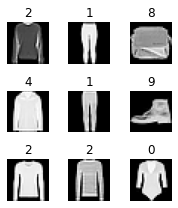

In [ ]:
#export
# Kiểm tra dữ liệu:
plt.figure(figsize=(3, 3))
for images in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(np.repeat(images[0][i], 3, -1))
        plt.title(images[1][i].numpy())
        plt.axis('off')
        plt.tight_layout()

### Biến đổi dữ liệu
> Tương tự như ở trên, chúng ta có 2 biến đổi dữ liệu cơ bản là rescale dữ liệu về khoảng 0-1 và sau đó normalize lại dữ liệu về khoảng mean + variance được xác định trươc. Ở đây mean và variance được sử dụng là của dữ liệu trong imagenet.

__Lưu ý:__ với tensorflow dataset, chúng ta muốn biến đổi dữ liệu cần áp dụng mapping với dữ liệu này, sử dụng phương pháp: `tf.data.Dataset.map`

In [ ]:
#export
def rescale_pixel(image, label):
    image = tf.cast(image, tf.float32)/255.
    return (image, label)

def normalize_img(image, label):
    normalizer = keras.layers.experimental.preprocessing.Normalization(mean=.485, variance=.229**2)
    image = normalizer(image)
    return (image, label)

train_ds = train_ds.map(rescale_pixel)
train_ds = train_ds.map(normalize_img)
valid_ds = valid_ds.map(rescale_pixel)
valid_ds = valid_ds.map(normalize_img)

__Lưu ý:__ Khi thực hiện việc biến đổi dữ liệu này, với tf 2.4.1 và keras 2.4.0, chúng ta bị lỗi: 

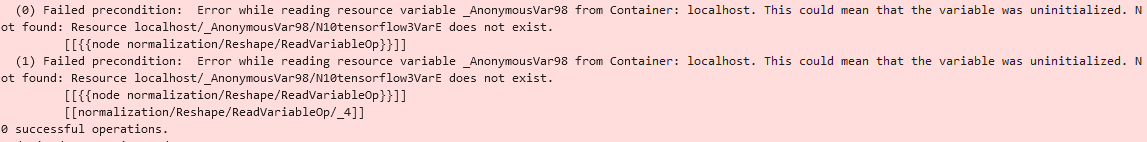

Nếu không sử dụng việc biến đổi dữ liệu này vs dữ liệu gốc thì sẽ không bị lỗi vậy. Tuy nhiên, lỗi này không thực sự ổn định. Nếu chúng ta sử dụng pycharm vs cùng setup môi trường và version của tf, keras thì không có lỗi trên.

#### Tạo neural net cơ bản:

In [ ]:
#export
model = keras.Sequential()
model.add(keras.layers.Flatten(input_shape=(28, 28, 1), name='flatten'))
model.add(keras.layers.Dense(128, activation='relu', name='layer1'))
model.add(keras.layers.Dropout(0.5, name='dropout'))
model.add(keras.layers.Dense(20, activation='relu', name='layer2'))
model.add(keras.layers.Dense(10, activation='softmax', name='prediction'))

In [ ]:
#export
# Create optimizer and loss_fuction
optimizer = keras.optimizers.RMSprop(learning_rate=0.001)
loss_func = keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer=optimizer, loss=loss_func, metrics='accuracy')

In [ ]:
#export
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
layer1 (Dense)               (None, 128)               100480    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
layer2 (Dense)               (None, 20)                2580      
_________________________________________________________________
prediction (Dense)           (None, 10)                210       
Total params: 103,270
Trainable params: 103,270
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#export
model.fit(train_ds, epochs=5, validation_data=valid_ds)

Epoch 1/5
938/938 [==============================] - 15s 16ms/step - loss: 1.2742 - accuracy: 0.5132 - val_loss: 1.1417 - val_accuracy: 0.5555
Epoch 2/5
938/938 [==============================] - 15s 16ms/step - loss: 1.1920 - accuracy: 0.5527 - val_loss: 1.0550 - val_accuracy: 0.6048
Epoch 3/5
 49/938 [>.............................] - ETA: 13s - loss: 1.0748 - accuracy: 0.6110

__Lưu ý:__ Kết quả này chưa bao gồm việc xử lý dữ liệu: rescale và normalize